In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from glitchpy.supportGlitch import smoothComponent, totalGlitchSignal, glitchSignal, averageAmplitudes
from glitchpy.supportGlitch import fit

from astroquery.vizier import Vizier

In [2]:
v = Vizier(row_limit=-1)
tables = v.query_constraints("J/ApJ/835/172/table6", KIC="12069424")
df = tables[0].to_pandas()
mask = (df.l == 0) & (df.lnK == 6.0)
df = df.loc[mask]
df

,KIC,n,l,Freq,e_Freq,E_Freq,Amp,e_Amp,E_Amp,Width,e_Width,E_Width,l_lnK,lnK
1,12069424,12,0,1390.80819,0.75733,0.96935,1.03512,0.14780,0.20868,1.37054,0.52924,4.48112,>,6.0
4,12069424,13,0,1495.05303,0.24309,0.22749,0.95483,0.05547,0.11515,1.81378,0.44172,0.75230,>,6.0
7,12069424,14,0,1598.68962,0.07498,0.06914,1.22720,0.05720,0.08730,0.78436,0.12820,0.24575,>,6.0
10,12069424,15,0,1700.95243,0.10148,0.10134,1.63692,0.07382,0.05323,1.41792,0.17727,0.20838,>,6.0
13,12069424,16,0,1802.35128,0.08378,0.07515,2.16288,0.06928,0.06374,1.29415,0.16222,0.09853,>,6.0
16,12069424,17,0,1904.52077,0.05845,0.05825,2.58001,0.08843,0.05659,1.04231,0.07605,0.12258,>,6.0
19,12069424,18,0,2007.53798,0.04187,0.04726,3.28737,0.09241,0.07175,1.00270,0.06517,0.07839,>,6.0
23,12069424,19,0,2110.94955,0.03737,0.04407,3.85151,0.05937,0.11127,0.81538,0.05443,0.05549,>,6.0
27,12069424,20,0,2214.22506,0.05468,0.05287,4.03359,0.07931,0.11501,1.22038,0.07071,0.07990,>,6.0
31,12069424,21,0,2317.28211,0.05534,0.05855,3.61470,0.04919,0.10279,1.24285,0.09264,0.05525,>,6.0


In [12]:
l, n, nu, nu_low, nu_high = df.l.to_numpy(), df.n.to_numpy(), df.Freq.to_numpy(), df.e_Freq.to_numpy(), df.E_Freq.to_numpy()
nu_err = np.stack([nu_low, nu_high]).max(axis=0)
freq = np.stack([l, n, nu, nu_err], axis=-1)

# Lund et al. (2017)
delta_nu = 103.28

<ErrorbarContainer object of 3 artists>

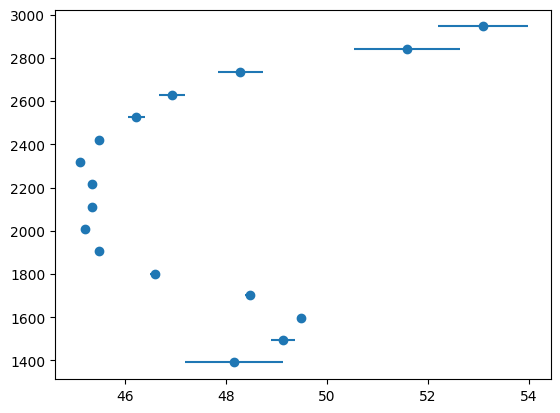

In [13]:
fig, ax = plt.subplots()

ax.errorbar(freq[:, 2]%delta_nu, freq[:, 2], xerr=freq[:, 3], fmt="o")

In [14]:
num_of_l = np.unique(freq[:, 0]).shape[0]
num_of_n = np.zeros(num_of_l, dtype=int)
for i in range(num_of_l):
    num_of_n[i] = freq[freq[:, 0] == i].shape[0]
    
tol_grad = 1e-3

In [16]:
n_rln = 1000
reg = 7.0
n_guess = 200

param, chi2, reg, ier, ratio = fit(
    freq, num_of_n, delta_nu, n_rln=n_rln, tol_grad=tol_grad, regu_param=reg, n_guess=n_guess,
)

100%|██████████| 1000/1000 [02:26<00:00,  6.83it/s]


In [17]:
param_names = [
    "b0",
    "b1",
    "b2",
    "b3",
    "b4",
    "a_cz",
    "tau_cz",
    "phi_cz",
    "a_he",
    "delta_he",
    "tau_he",
    "phi_he",
]

In [18]:
samples = np.concatenate((param, chi2[:, None], reg[:, None]), axis=1)
samples_names = param_names + ["chi2", "reg"]

In [19]:
df = pd.DataFrame(samples, columns=samples_names)
df.head()

,b0,b1,b2,b3,b4,a_cz,tau_cz,phi_cz,a_he,delta_he,tau_he,phi_he,chi2,reg
0,218.470902,92.155771,0.720444,-0.023672,0.000335,3.225652e+06,2445.623579,1.202641,0.008262,107.295160,977.336113,6.167796,9.487531,1.246045
1,161.338540,103.190012,-0.059707,0.000263,0.000066,4.236580e+05,2928.202972,1.215468,0.008558,106.095126,905.007540,1.669212,2.029456,0.873090
2,167.464018,101.660459,0.083359,-0.005671,0.000158,2.743181e+05,2971.123826,0.405216,0.008084,105.419780,931.899544,1.099660,14.856376,1.487741
3,169.353104,101.895584,0.012772,-0.001379,0.000079,2.604893e+05,2961.388406,0.428327,0.006321,100.981822,900.804694,1.781135,8.956390,0.701627
4,193.656327,96.524046,0.454494,-0.017340,0.000292,1.082327e+06,2463.555071,0.728469,0.007621,102.434578,897.282317,1.659063,6.127516,1.651096


In [20]:
# filepath = os.path.expanduser(f"~/OneDrive/Data/alexlyttle/thesis/v19-glitch-samples-{name}.csv")
filepath = f"data/v19-glitch-results-16cyga.csv"
df.to_csv(filepath)

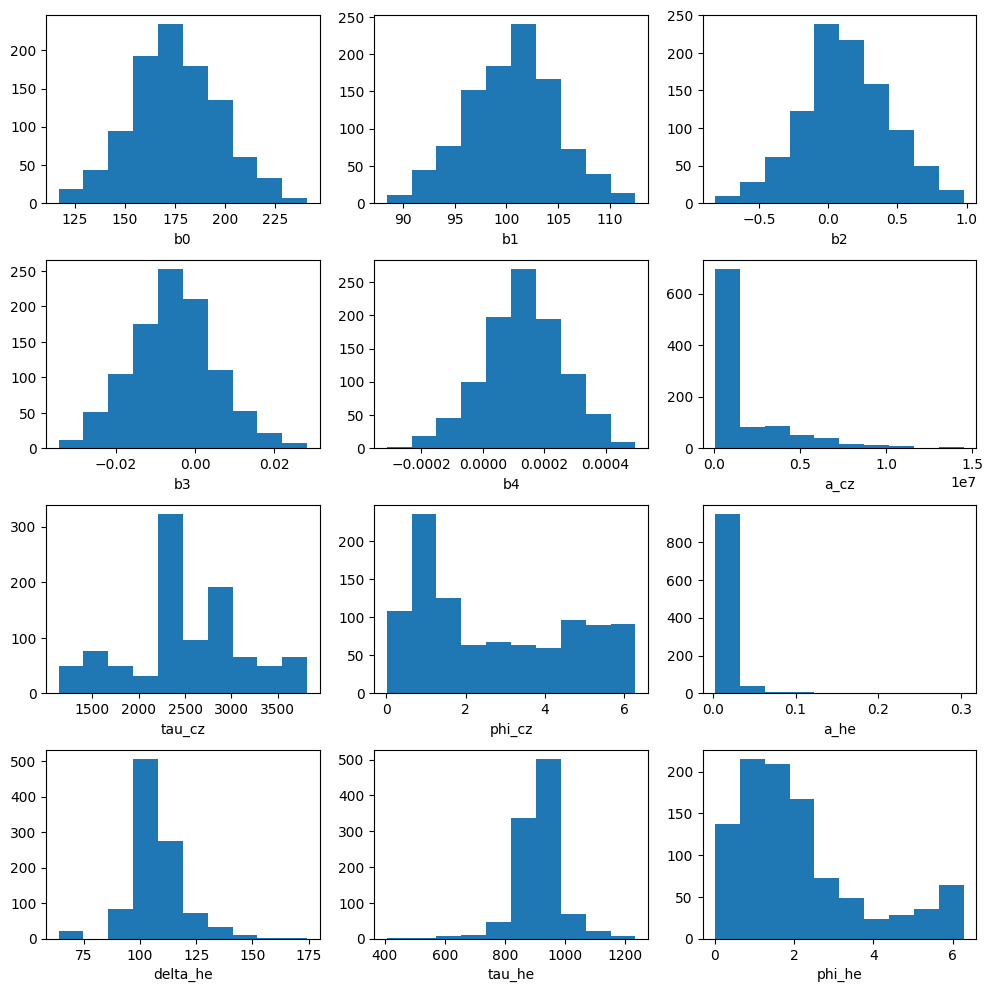

In [21]:
fig, axes = plt.subplots(4, 3, figsize=(12, 12), gridspec_kw={"hspace": 0.3})

for i, ax in enumerate(axes.ravel()):
    ax.hist(param[:-1, i])
    ax.set_xlabel(param_names[i])

In [23]:
def helium_at_nu(param, nu):
    return param[:, -4] * nu * np.exp(- 8e-12 * np.pi**2 * param[:, -3]**2 * nu**2)

In [24]:
nu_max = 2188.5
amp_numax = helium_at_nu(param, nu_max)

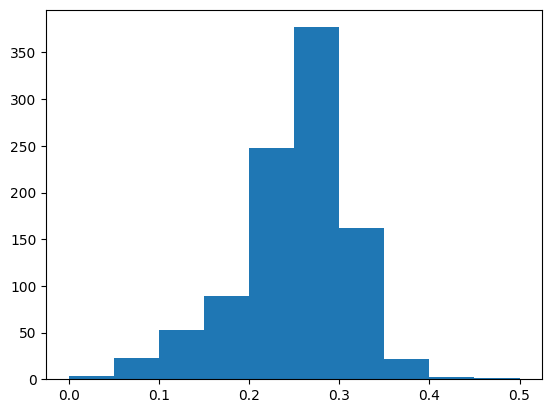

In [25]:
plt.hist(amp_numax, range=(0., 0.5));

In [26]:
def _oscillation(nu, tau, phi):
    return np.sin(4 * np.pi * tau * nu + phi)

def poly(p, x):
    powers = np.arange(p.shape[-1])
    return np.sum(p*x[..., None]**powers, axis=-1)

def smooth_component(param, n, npoly_params=5):
    return np.apply_along_axis(
        poly, 
        -1,
        param[..., :npoly_params], 
        n,
    )

def helium_amp(param, nu):
    return param[..., -4, None] * nu * np.exp(- 8e-12 * np.pi**2 * param[..., -3, None]**2 * nu**2)

def helium_glitch(param, nu):
    return helium_amp(param, nu) * _oscillation(nu, 1e-6*param[..., -2, None], param[..., -1, None])

def bcz_amp(param, nu):
    return param[..., -7, None] / nu**2

def bcz_glitch(param, nu):
    return bcz_amp(param, nu) * _oscillation(nu, 1e-6*param[..., -6, None], param[..., -5, None])

def glitch(param, nu):
    return helium_glitch(param, nu) + bcz_glitch(param, nu)

In [27]:
from corner import corner

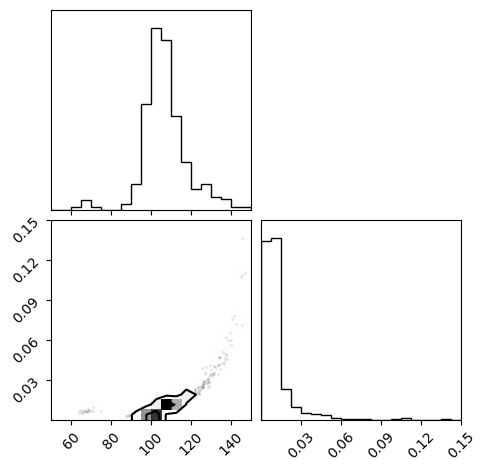

In [28]:
corner(param[:, [-3, -4]], range=[(50, 150), (0, 0.15)]);

In [29]:
nu_sm = smooth_component(param, freq[:, 1])
dnu = glitch(param, nu_sm)
nu = nu_sm + dnu

In [30]:
thin = 20

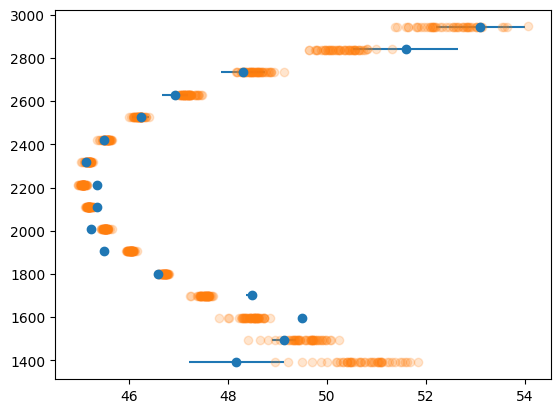

In [32]:
fig, ax = plt.subplots()

ax.errorbar(freq[:, 2]%delta_nu, freq[:, 2], xerr=freq[:, 3], fmt="o")
ax.plot(nu_sm[::thin]%delta_nu, nu_sm[::thin], "o", color="C1", alpha=0.2);
# ax.plot(nu%delta_nu, nu, "o", markerfacecolor="none")
# ax.set_xlim(50, 60)

In [33]:
num_points = 501
nu_pred = np.linspace(freq[:, 2].min(), freq[:, 2].max(), num_points)
dnu_pred = glitch(param, nu_pred)

In [34]:
dnu_he_pred = helium_glitch(param[-1, :], nu_pred)
dnu_cz_pred = bcz_glitch(param[-1, :], nu_pred)

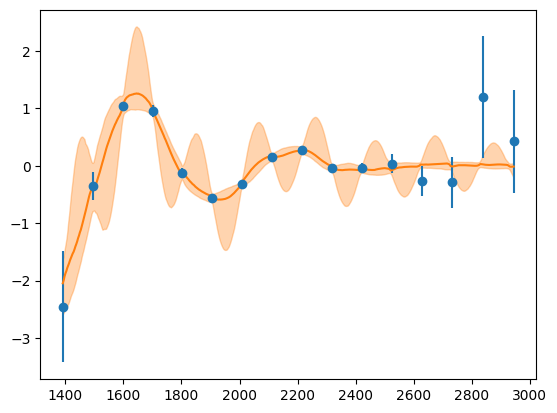

In [35]:
fig, ax = plt.subplots()
ax.errorbar(freq[:, 2], freq[:, 2] - np.median(nu_sm, axis=0), yerr=freq[:, 3], fmt="o", color="C0", label="data")
# ax.plot(nu_pred[::thin].T, dnu_pred[::thin].T, alpha=0.2, color="C0")


dnu_med = np.median(dnu_pred, axis=0)
dnu_lower, dnu_upper = np.quantile(dnu_pred, [.16, .84], axis=0)

ax.plot(nu_pred, dnu_med, color="C1")
ax.fill_between(nu_pred, dnu_lower, dnu_upper, color="C1", alpha=0.33)
# ax.plot(nu_pred, dnu_he_pred, label="He")
# ax.plot(nu_pred, dnu_cz_pred, label="CZ")
# ax.set_ylim(-5, 5)
# ax.legend();

Difference between prediciton and truth

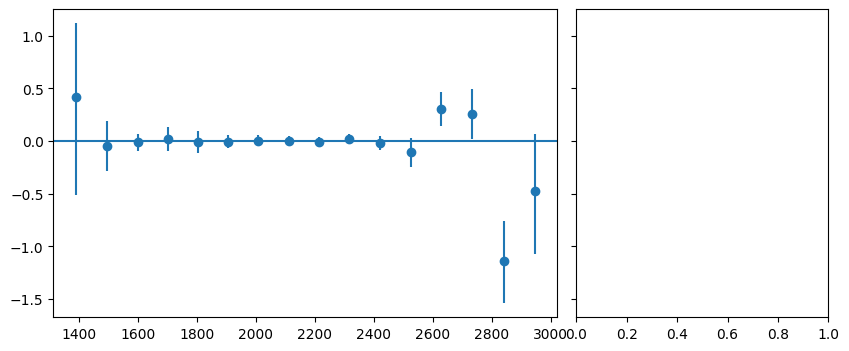

In [36]:
res = nu - freq[:, 2]
res_med = np.median(res, axis=0)
res_unc = np.abs(res_med - np.quantile(res, [.16, .84], axis=0))

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True,
                         gridspec_kw={"wspace": 0.05, "width_ratios": [2, 1]})

ax = axes[0]
ax.errorbar(freq[:, 2], res_med, yerr=res_unc, fmt="o")
# for l in range(num_of_l):
#     mask = freq[:, 0] == l
#     ax.plot(nu[mask], res[mask], "o", label=l)
    

ax.axhline()
# ax.legend()

ax = axes[1]
# ax.hist(res.flatten(), orientation="horizontal", color="k", histtype="step");

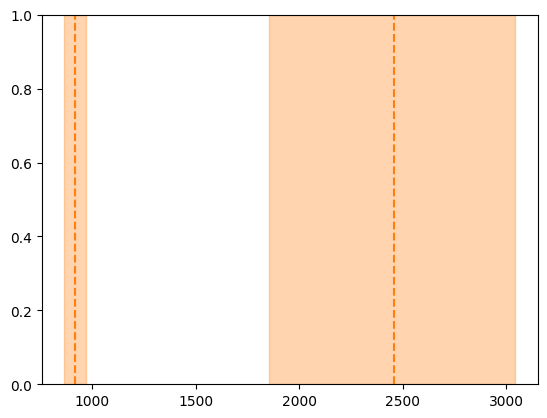

In [37]:
plt.axvline(np.median(param[:, -2]), c="C1", ls="--")
plt.axvline(np.median(param[:, -6]), c="C1", ls="--")

plt.axvspan(*np.quantile(param[:, -2], [.16, .84]), color="C1", alpha=0.33)
plt.axvspan(*np.quantile(param[:, -6], [.16, .84]), color="C1", alpha=0.33)